# Sistem Rekomendasi Hotel Berbasis Konten (Content-Based Filtering)

**Tujuan Proyek:**
1. Memuat dan membersihkan data hotel yang telah di-scrape dari Traveloka.
2. Melakukan Exploratory Data Analysis (EDA) untuk memahami karakteristik data.
3. Membuat fitur-fitur baru seperti 'Skor Popularitas' untuk meningkatkan kualitas rekomendasi.
4. Membangun model rekomendasi berbasis konten menggunakan TF-IDF dan Cosine Similarity.
5. Memberikan rekomendasi hotel yang tidak hanya mirip, tetapi juga populer dan terpercaya.

## 1. Import Library

Langkah pertama adalah mengimpor semua library yang akan kita gunakan untuk analisis data, visualisasi, dan pembangunan model.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Pengaturan untuk tampilan plot dan dataframe
sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 50)

## 2. Memuat Data

Kita akan memuat dataset hotel yang telah berhasil dikumpulkan oleh skrip scraper Selenium. Pastikan nama file CSV sudah benar dan berada di direktori yang sama.

In [13]:
try:
    NAMA_FILE_CSV = 'data_hotel_lengkap_final.csv'
    df = pd.read_csv(NAMA_FILE_CSV)
    print(f"Berhasil memuat {len(df)} data dari '{NAMA_FILE_CSV}'")
    display(df.head())
except FileNotFoundError:
    print(f"Error: File '{NAMA_FILE_CSV}' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan skrip scraping dan nama filenya benar.")

Berhasil memuat 1809 data dari 'data_hotel_lengkap_final.csv'


,Nama Hotel,Tipe Properti,Bintang Hotel,Rating,Lokasi,Harga Diskon,Harga Asli,Fasilitas,URL Gambar
0,ARTOTEL Gelora Senayan Jakarta,Hotel,4,9.1 (778 ulasan),"Senayan, Jakarta",Rp 1.512.775,Rp 2.017.033,Restoran show cooking; Ruang santai; Sewa mobi...,https://ik.imagekit.io/tvlk/apr-asset/Ixf4aptF...
1,Hotel Indonesia Kempinski Jakarta,Hotel,5,8.9 (5rb ulasan),"Thamrin, Jakarta",Rp 3.418.919,Rp 4.558.558,Area main anak; Sewa mobil; Fasilitas bisnis; ...,https://ik.imagekit.io/tvlk/apr-asset/dgXfoyh2...
2,Merlynn Park Hotel,Hotel,5,8.6 (17rb ulasan),"Petojo Utara, Jakarta",Rp 724.306,Rp 965.741,Great value in its class; Tanda khusus bagi tu...,https://ik.imagekit.io/tvlk/apr-asset/Ixf4aptF...
3,Millennium Hotel Sirih Jakarta,Hotel,4,8.7 (6rb ulasan),"Tanah Abang, Jakarta",Rp 781.396,Rp 1.041.861,Pusat kebugaran; Aksesibel bagi penyandang dis...,https://ik.imagekit.io/tvlk/apr-asset/dgXfoyh2...
4,Front One Boutique Hotel Taman Anggrek,Hotel,3,9.1 (666 ulasan),"Tanjung Duren, Jakarta",Rp 269.779,Rp 359.705,Karaoke; Layanan pijat; Fasilitas bisnis; Akse...,https://ik.imagekit.io/tvlk/apr-asset/Ixf4aptF...


## 3. Exploratory Data Analysis (EDA) & Pembersihan Data

Pada tahap ini, kita akan menjelajahi data untuk memahami isinya, memeriksa nilai yang hilang, dan membersihkan kolom agar siap untuk dianalisis.

In [14]:
print("Informasi dasar DataFrame:")
df.info()

print("\nJumlah nilai kosong (null) di setiap kolom:")
print(df.isnull().sum())

Informasi dasar DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1809 entries, 0 to 1808
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Nama Hotel     1809 non-null   object
 1   Tipe Properti  1809 non-null   object
 2   Bintang Hotel  1809 non-null   int64 
 3   Rating         1364 non-null   object
 4   Lokasi         1809 non-null   object
 5   Harga Diskon   1809 non-null   object
 6   Harga Asli     1809 non-null   object
 7   Fasilitas      924 non-null    object
 8   URL Gambar     1048 non-null   object
dtypes: int64(1), object(8)
memory usage: 127.3+ KB

Jumlah nilai kosong (null) di setiap kolom:
Nama Hotel         0
Tipe Properti      0
Bintang Hotel      0
Rating           445
Lokasi             0
Harga Diskon       0
Harga Asli         0
Fasilitas        885
URL Gambar       761
dtype: int64


### 3.1. Membersihkan Kolom Harga, Rating, dan Jumlah Ulasan

Kolom `Harga Diskon` dan `Rating` masih dalam format teks. Kita perlu mengubahnya menjadi format angka (numerik) agar bisa diolah.

In [15]:
# Fungsi untuk membersihkan harga
def clean_price(price):
    if isinstance(price, str) and 'Rp' in price:
        # Hapus 'Rp ', '.', dan ubah ke integer
        return int(price.replace('Rp ', '').replace('.', ''))
    return np.nan

# Fungsi untuk memisahkan rating dan jumlah ulasan
def parse_rating(rating_str):
    if not isinstance(rating_str, str) or '(' not in rating_str:
        return None, None
    skor_match = re.search(r'^\s*([\d.]+)', rating_str)
    skor = float(skor_match.group(1)) if skor_match else None
    jumlah_match = re.search(r'\((\d+)', rating_str)
    jumlah = int(jumlah_match.group(1)) if jumlah_match else None
    return skor, jumlah

# Terapkan fungsi-fungsi di atas
df['Harga Numerik'] = df['Harga Diskon'].apply(clean_price)
df[['Skor Rating', 'Jumlah Ulasan']] = df['Rating'].apply(parse_rating).apply(pd.Series)

# Hapus baris yang datanya tidak lengkap setelah diproses
df.dropna(subset=['Skor Rating', 'Jumlah Ulasan', 'Harga Numerik', 'Tipe Properti'], inplace=True)

# Konversi tipe data ke tipe yang benar
df['Jumlah Ulasan'] = df['Jumlah Ulasan'].astype(int)
df['Bintang Hotel'] = df['Bintang Hotel'].astype(int)

print("Pembersihan data selesai. Tipe data setelah diubah:")
print(df[['Skor Rating', 'Jumlah Ulasan', 'Harga Numerik']].dtypes)

Pembersihan data selesai. Tipe data setelah diubah:
Skor Rating      float64
Jumlah Ulasan      int64
Harga Numerik      int64
dtype: object


### 3.2. Visualisasi Data

Visualisasi membantu kita memahami distribusi dan karakteristik data dengan lebih baik.

C:\Users\ICT-12\AppData\Local\Temp\ipykernel_29132\1801965840.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')


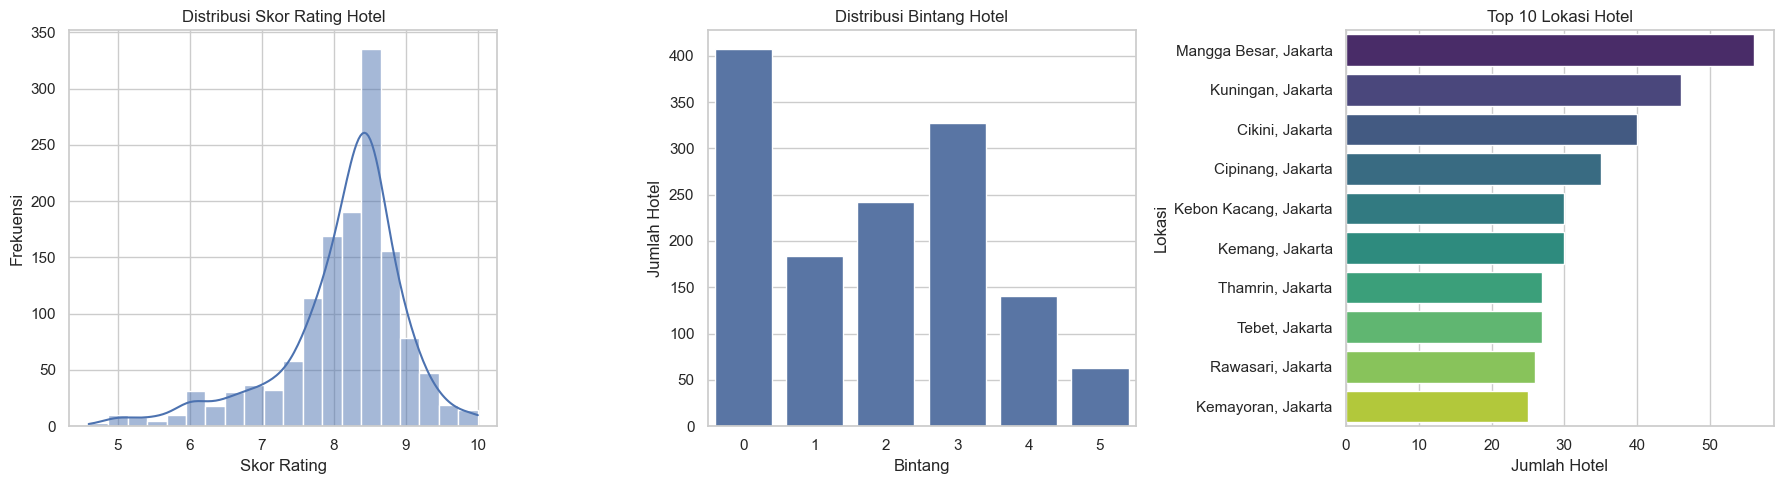

In [16]:
plt.figure(figsize=(18, 5))

# Distribusi Skor Rating
plt.subplot(1, 3, 1)
sns.histplot(df['Skor Rating'], bins=20, kde=True)
plt.title('Distribusi Skor Rating Hotel')
plt.xlabel('Skor Rating')
plt.ylabel('Frekuensi')

# Distribusi Bintang Hotel
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='Bintang Hotel')
plt.title('Distribusi Bintang Hotel')
plt.xlabel('Bintang')
plt.ylabel('Jumlah Hotel')

# Top 10 Lokasi Hotel
plt.subplot(1, 3, 3)
top_locations = df['Lokasi'].value_counts().nlargest(10)
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
plt.title('Top 10 Lokasi Hotel')
plt.xlabel('Jumlah Hotel')
plt.ylabel('Lokasi')

plt.tight_layout()
plt.show()

## 4. Feature Engineering

Kita akan membuat dua fitur kunci:
1.  **Skor Popularitas:** Gabungan dari skor rating dan jumlah ulasan untuk mendapatkan skor yang lebih adil.
2.  **Fitur Konten:** Gabungan dari `Lokasi`, `Fasilitas`, dan `Tipe Properti` untuk dianalisis oleh model.

In [17]:
# Menghitung Skor Popularitas (Weighted Rating IMDB)
C = df['Skor Rating'].mean()
m = df['Jumlah Ulasan'].quantile(0.75) # Batas minimum adalah kuantil ke-75

def calculate_weighted_rating(row, m=m, C=C):
    v = row['Jumlah Ulasan']
    R = row['Skor Rating']
    return (v / (v + m)) * R + (m / (v + m)) * C

df['Skor Popularitas'] = df.apply(calculate_weighted_rating, axis=1)

print("Top 5 Hotel Berdasarkan Skor Popularitas Baru:")
display(df.sort_values('Skor Popularitas', ascending=False)[['Nama Hotel', 'Skor Rating', 'Jumlah Ulasan', 'Skor Popularitas']].head())

# Menggabungkan Fitur untuk Content-Based Filtering
df['features'] = (
    df['Lokasi'].fillna('').str.lower().str.replace(',', ' ') + ' ' + 
    df['Fasilitas'].fillna('').str.lower().str.replace('; ', ' ') + ' ' + 
    df['Tipe Properti'].fillna('').str.lower()
)

print("\nContoh gabungan fitur untuk satu hotel:")
print(df['features'].iloc[0])

Top 5 Hotel Berdasarkan Skor Popularitas Baru:


,Nama Hotel,Skor Rating,Jumlah Ulasan,Skor Popularitas
169,BW Express Jakarta Tanah Abang,9.4,415,9.152884
161,Ashley Tugu Tani Menteng,9.5,238,9.093935
111,Ashley Tanah Abang,9.1,983,9.010223
44,Ashley Tang Menteng,9.1,874,9.000178
208,Citadines Gatot Subroto Jakarta,9.3,288,8.997872



Contoh gabungan fitur untuk satu hotel:
senayan  jakarta restoran show cooking ruang santai sewa mobil layanan pijat hotel


## 5. Pembangunan Model Content-Based Filtering

Sekarang kita ubah fitur teks menjadi matriks numerik menggunakan `TfidfVectorizer` dan hitung kemiripan antar hotel menggunakan `cosine_similarity`.

In [18]:
tfidf = TfidfVectorizer(stop_words='indonesian')

tfidf_matrix = tfidf.fit_transform(df['features'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Ukuran matriks TF-IDF:", tfidf_matrix.shape)
print("Ukuran matriks Cosine Similarity:", cosine_sim.shape)
print("Model berhasil dibangun!")

InvalidParameterError: The 'stop_words' parameter of TfidfVectorizer must be a str among {'english'}, an instance of 'list' or None. Got 'indonesian' instead.

## 6. Membuat dan Menguji Fungsi Rekomendasi

Fungsi ini akan mengambil nama hotel sebagai input dan mengembalikan daftar hotel lain yang paling mirip.

In [ ]:
# Membuat mapping antara nama hotel dan indeks DataFrame
indices = pd.Series(df.index, index=df['Nama Hotel']).drop_duplicates()

def recommend_hotel(hotel_name, cosine_sim=cosine_sim):
    try:
        idx = indices[hotel_name]
    except KeyError:
        return f"Hotel dengan nama '{hotel_name}' tidak ditemukan."

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    hotel_indices = [i[0] for i in sim_scores]
    return df.iloc[hotel_indices]

### Demonstrasi Hasil Akhir

In [ ]:
# --- PILIH NAMA HOTEL DARI DATASET ANDA UNTUK DIUJI ---
# Ambil hotel dengan jumlah ulasan terbanyak sebagai contoh yang baik
NAMA_HOTEL_CONTOH = df.loc[df['Jumlah Ulasan'].idxmax()]['Nama Hotel']

if NAMA_HOTEL_CONTOH not in indices:
    print(f"'{NAMA_HOTEL_CONTOH}' tidak ditemukan di dataset.")
else:
    print(f"REKOMENDASI UNTUK: '{NAMA_HOTEL_CONTOH}'")
    print("-" * 50)
    
    rekomendasi = recommend_hotel(NAMA_HOTEL_CONTOH)
    
    # Mengurutkan rekomendasi akhir berdasarkan Skor Popularitas
    rekomendasi_terurut = rekomendasi.sort_values('Skor Popularitas', ascending=False)
    
    # Tampilkan hasil yang paling relevan
    display(rekomendasi_terurut[['Nama Hotel', 'Tipe Properti', 'Lokasi', 'Skor Rating', 'Jumlah Ulasan', 'Skor Popularitas', 'Harga Numerik']])


REKOMENDASI UNTUK: 'Pejaten Valley Residence'
--------------------------------------------------


,Nama Hotel,Tipe Properti,Lokasi,Skor Rating,Jumlah Ulasan,Skor Popularitas,Harga Numerik
657,D'rhea Syariah,Hotel,"Pejaten Barat, Jakarta",8.8,316,8.638615,266175
368,Cove Arimbi,Hotel,"Pejaten Barat, Jakarta",8.7,231,8.527468,260101
658,Super OYO Capital O 133 Griya Ciaji,Guest House,"Pejaten Barat, Jakarta",8.3,352,8.262297,392335
1079,Pejaten Valley Residence By Zuzu,Hotel,"Pejaten Barat, Jakarta",10.0,1,8.148382,356620
1157,Comfort And Modern Look 3Br Apartment Royal Ol...,Apartemen,"Pejaten Barat, Jakarta",8.5,1,8.133567,1211417
880,Hester Basoeki ( HB ) Garden Guest House,Guest House,"Cilandak Barat, Jakarta",8.1,106,8.114539,314880
906,RedDoorz Syariah near Prasetya Mulya Cilandak ...,Guest House,"Cilandak Barat, Jakarta",8.0,112,8.061360,225184
488,Cove Birah at Senopati,Guest House,"Rawa Barat, Jakarta",8.0,121,8.058864,288777
1268,Residence 21 Syariah,Hotel,"Pejaten Barat, Jakarta",6.1,6,8.015282,144186
720,OYO 121 Rumah Ayub Syariah Near Rumah Sakit Jmc,Hotel,"Pejaten Barat, Jakarta",7.5,498,7.605556,225713


## Kesimpulan

Kita telah berhasil membangun sebuah sistem rekomendasi hotel dari awal hingga akhir.

1.  **Data Collection:** Menggunakan Selenium untuk scraping data dinamis.
2.  **Data Cleaning:** Mengubah data mentah menjadi data numerik yang siap pakai.
3.  **EDA:** Memahami karakteristik data melalui visualisasi.
4.  **Feature Engineering:** Menciptakan 'Skor Popularitas' yang lebih adil daripada rating biasa.
5.  **Modeling:** Menerapkan TF-IDF dan Cosine Similarity untuk menemukan kemiripan berdasarkan konten (`Lokasi`, `Fasilitas`, `Tipe Properti`).
6.  **Recommendation:** Menghasilkan daftar hotel yang tidak hanya mirip secara konten tetapi juga populer dan kredibel.

Proyek ini menunjukkan alur kerja lengkap seorang data scientist dalam membangun sistem rekomendasi.